# Problem sheet 4 - Q3: PCA and ICA

1. [Data preparation](#1)
2. [PCA](#2)
3. [ICA](#3)
4. [Next steps](#4)

A common issue in computer vision is that the dimension of the ambient space (i.e. $\text{height}\ast\text{width}\ast\text{channels}$) grows quadratically in terms of the sidelengths. So even for small, say, 224x224 black and white pictures we end up with a massive 50176 different dimensions. If all of the features were independent, this would lead to extremely complicated models. For most image datasets this is luckily not the case and we can apply various *dimensionality reduction* techniques. In this exercise we implement two of these: *principal component analysis* (PCA) and *independent component analysis* (ICA).

Both of these methods work to extract features from the original data that they deem important, but the underlying ideas are fairly different. In PCA we construct vectors in the ambient space which we hope capture the highest amount of variance of the original sample distribution if we were to project our data onto them. Consider the following dataset along with the two vectors $\mathbf{v}_{1}$ and $\mathbf{v}_{2}$.

!["PCA visualisation"](pca.jpg 'PCA visualisation')

On the right you can see how the data would look if we were to project it onto $\mathbf{v}_{1}$ or $\mathbf{v}_{2}$, respectively. Clearly the projection to $\mathbf{v}_{1}$ captures the distribution of the original data better. So how do we find such good directions? It seems we should first pick a basis for our ambient space, project the data to each of the basis vectors and then pick the directions where the projection retains the highest amount of variance. Not all bases are equal, though. For example, in the above example if we had instead used the standard basis $\{\mathbf{i}, \mathbf{j}\}$ then this would result in two correlated features which would both capture less of the variance than when we projected to $\mathbf{v}_{1}$. More precisely, what we want need is to find a unit vector (direction) $\mathbf{\hat{u}}$ that maximises
$$\sum_{i}\bigl(x^{(i)}\cdotp\mathbf{\hat{u}}\bigr)^{2}.$$
It is possible to show that such vectors are precisely the eigenvectors of the empirical covariance matrix $XX^{T}$ (assuming we have normalised the mean to be zero).

In ICA we make stronger assumptions about the data. First of all, we assume that the data is generated by a linear combination of samples from some independent latent variables (we'll call these *sources*), that is, each $x$ satisfies $x=As$, where the components $s_{i}$ of $s$ are the sources, which are iid according to some prior distribution that we have to pick ourselves, and $A$ is the *mixing matrix*, which describes how the sources are combined. The ICA algorithm then provides us with the *unmixing matrix* $W$ such that for each sample point we have $s^{(i)}=Wx^{(i)}$. For simplicity we assume that $A$ is a square matrix. In image processing this means that we expect that all of our pictures are composed by overlaying some specific set of independent fundamental features (e.g. various lines or blobs) on top of each other.

There are several limitations to ICA. It cannot tell us the relative importance of the sources since $[A_{1}\ldots\lambda^{-1}A_{i}\ldots A_{d}](s_{1},\ldots,\lambda s_{i},\ldots, s_{d})^{T}=As$, where $A_{i}$ is the *i*-th column of $A$. Moreover ICA does not work if the $s_{i}$ are Gaussian. This is because then the $x^{(i)}$ would be linear combinations of independent Gaussians which is also Gaussian and so the resulting vector is multivariate Gaussian which is invariant under the orthogonal group $\mathrm{O}(d)$ when properly normalised. However, when ICA is applicable then it tends to yield much better (and more interesting) solutions than PCA.

In this exercise we implement the following version of ICA to find the matrix $W$: first assume that the cdf of each $s_{i}$ is given by the sigmoid function $g$ so that $p_{s}(s_{j})=g'(s_{j})$. It follows from our assumptions that the joint pdf of $s$ is then given by $p(s)=\prod p_{s}(s_{j})$. We can then obtain the distribution of $x$ by transforming $p$ with $W$ giving $p_{x}(x)=p(Wx)\cdot\det W=\prod p_{s}(Wx)\cdot\det W$. Now we just need to maximise the (log) likelihood of $W$ given our training set, that is we want to maximise
$$\ell(W)=\sum_{i}\log p_{x}(x^{(i)}).$$
We will do this with mini-batch gradient descent.

## 1. Data preparation<a id="1"></a>

For this exercise we will work with a couple of pictures of plants from the [PlantCLEF 2017](https://www.imageclef.org/lifeclef/2017/plant) dataset.

In [1]:
%matplotlib inline
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.linalg import fractional_matrix_power
from scipy.special import expit

from PIL import Image

We split each image into patches of size $16\times16$ and collect them all in the design matrix $X$, where each *column* corresponds to one patch (contrary to our usual convention). Then $X$ has to be preprocessed in the appropriate way for both algorithms. For PCA we simply define
$$X_{\text{pca}}:=\frac{X-\mu}{\sigma},$$
where $\mu$ is the mean and $\sigma$ the standard deviation of each pixel in our data (i.e. across the $16\times16$ patches).

For ICA, however, the process is more complicated. We follow the procedure of [Bell and Sejnowski](https://www.sciencedirect.com/science/article/pii/S0042698997001211) (1997). First they construct the "local whitening filter" (i.e. the solution of $s=Wx$ assuming that $W$ is symmetric and that the covariance matrix of $s$ is the identity matrix) $W_{Z}$ as (see equation (8)):
$$W_{Z} = (m^{-1}XX^{T})^{-1/2},$$
where $m$ is the number of patches. Then, set (see (18)):
$$X_{\text{ica}}:=2 W_{Z}(X-\mu),$$
where the vector $\mu$ is again the mean of each pixel in the patches.

In [2]:
img_folder = 'img'

patch_size = 16

X = np.zeros((patch_size ** 2, 4 * ceil(518 * 774 / patch_size ** 2)))  # roughly the expected size for 4 images

idx = 0

for n in range(1,5):  # 4 pictures which we resize and convert to greyscale
    img_obj = Image.open(os.path.join(img_folder, f"{n}.jpg")).resize((518, 774))
    img_obj = img_obj.convert('L')
    image = np.array(img_obj)
    height, width = img_obj.height, img_obj.width
    image = image[:,:].flatten().reshape((height, width))
    for j in range(int(height / patch_size)):
        for i in range(int(width / patch_size)):
            patch = image[j * patch_size : (j+1) * patch_size,
                          i * patch_size : (i+1) * patch_size]
            X[:, idx] = patch.flatten()
            idx += 1
    print(f"Image {n} - width: {width}, height: {height}, index: {idx}")

X = X[:, :idx]
X_pca = (X - X.mean(axis=1).reshape(-1,1))  / X.std(axis=1).reshape(-1,1)

W_z = (fractional_matrix_power((1/X.shape[1]) * X @ X.T, -0.5)).real
X_ica = X - X.mean(axis=1).reshape(-1,1)
X_ica = 2 * W_z @ X_ica

Image 1 - width: 518, height: 774, index: 1536
Image 2 - width: 518, height: 774, index: 3072
Image 3 - width: 518, height: 774, index: 4608
Image 4 - width: 518, height: 774, index: 6144


Below you can see the pictures that we chose.

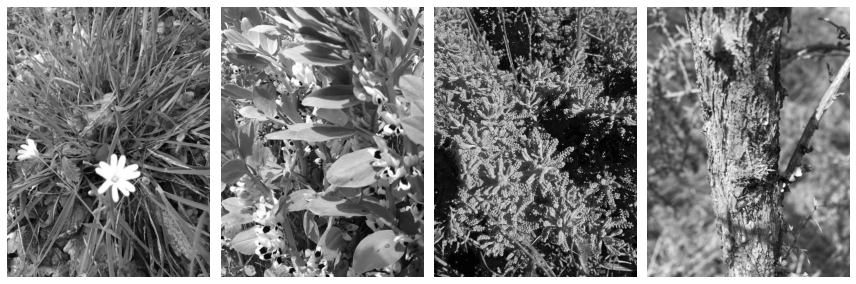

In [3]:
fig, ax = plt.subplots(1,4,figsize=(12,8))
fig.set_tight_layout(True)
fig.tight_layout(pad=1)
n = 1
for i in range(4):
    img = Image.open(os.path.join(img_folder, f"{n}.jpg")).convert('L')
    ax[i].imshow(img, cmap='gray')
    ax[i].axis(False)
    n+=1

## 2. PCA<a id="2"></a>

We can now implement the PCA algorithm described in the introduction.

In [4]:
# this function essentially equivalent to just using np.linalg.svd
# and picking k columns (since svd returns them sorted)

def PCA(X, k):
    n = X.shape[1]
    Sigma = X @ X.T
    lambda_eig, v_eig = np.linalg.eig(Sigma)
    v_eig = v_eig.real
    lambda_eig = lambda_eig.real
    
    # v_eig[:,i] is the i-th eigenvector
    # sort according to norm (descending)
    idx_list = np.argsort(-np.abs(lambda_eig))
    v_eig = v_eig[:, idx_list]
    # select k largest eigenvectors
    v_eig = v_eig[:, :k]
    #now project X to R^k in terms of the basis v_eig
    y = (v_eig.T @ X)
    return y, v_eig

Let's look at the most important PCA vectors for our dataset.

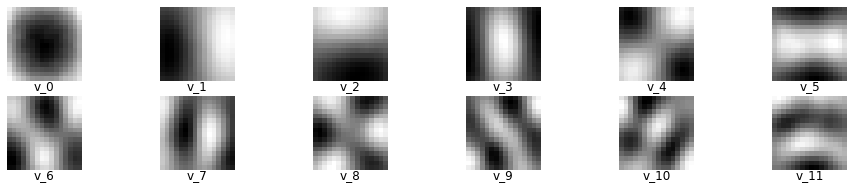

In [5]:
y, v_eig = PCA(X_pca, 12)

vecs = v_eig.shape[1]
cols = min(6, vecs)
rows = max(1, vecs // 6)
fig, ax = plt.subplots(rows, cols, figsize=(16,int(vecs*0.32)),sharex='all',sharey='all')

for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(v_eig[:, i * 6 + j].reshape((patch_size, patch_size)),cmap='gray')
        ax[i, j].axis(False)
        ax[i, j].set_title(f"v_{i * 6 + j}", y=-0.2)

We see that these are not so informative and don't seem to capture features of the data in a way that is very descriptive. On the other hand, if we had run PCA on the full pictures instead of patches then it is likely that PCA would yield more interesting results, but this is computationally expensive. The fact that PCA fails to find descriptive features present in the original data was one of the motivating reasons for using ICA instead. Let's see what happens there.

## 3. ICA<a id="3"></a>
Recall that we need to maximise the log likelihood function $\ell(W)$ given in the introduction. We can expand $\ell$ as
$$\ell(W) = \sum_{i=1}^{N}\sum_{j}\log p_{s}(w_{j}^{T}x^{(i)})+N\log(\det W),$$
where $x^{(i)}$ is the vector which contains the values for the $i$-th pixel in each patch, $w_{j}$ is the $j$-th row of $W$ and $N$ is the total number of patches. Since $p_{s}$ is the derivative of the sigmoid function (call it $g$), we see easily that
$$\frac{d}{dt}\log p_{s}(t) = \frac{d}{dt}\log (g(t)(1-g(t)) = 1-2g(t).$$
This along with the fact that the matrix derivative of the determinant is the transpose of the adjugate (for invertible matrices) gives us the update rule (see equation (11)):
$$W:=W + \alpha ((\mathbf{1}-2g(W x^{(i)}))(x^{(i)})^{T} + (W^{T})^{-1}),$$
where $\alpha$ is the learning rate, $\mathbf{1}$ is a vector of size $16^{2}$ with entries equal to one and $g$ is applied elementwise.

In [6]:
def ICA(X, alpha=0.0005, g=expit, iters=10, batch_size=100):
    # We use scipy.special.expit instead of simply
    # 1 / (1 + np.exp(-z)) because otherwise we run
    # into precision issues
    
    n, m = X.shape
    W = np.identity(n)

    rng = np.random.default_rng()

    for i in range(iters):
        # we pick a random set of patches for each batch
        x_icoords = rng.permuted(np.arange(m))
        W_old = W.copy()
        for j in range(int(m / batch_size)):
            x_is = X[:, x_icoords[j * batch_size:(j+1)*batch_size]]
            W = (W + alpha * ((1 - 2 * g(W @ x_is)) @ x_is.T + batch_size * np.linalg.inv(W.T))).real
            
    return W

Let's now run our algorithm. It returns us the matrix $W$, which we then have to use to reconstruct the original sources (i.e. we want to get the patches that ICA thinks were used to create our original dataset). We do this below and then plot some of the individual source patches $s_{i}$ in a grid.

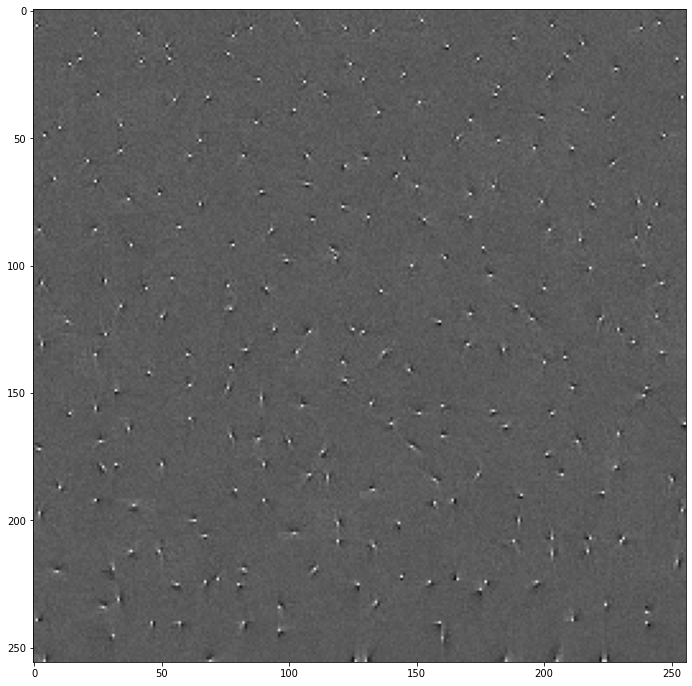

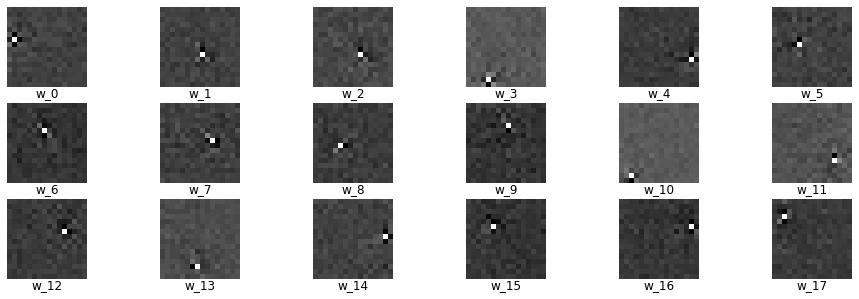

In [7]:
W = ICA(X_ica)

idx_list = np.argsort(-np.linalg.norm(W @ W_z,axis=1))

F_size = (patch_size) * (patch_size)
F = np.zeros((F_size, F_size))

for i in range(patch_size):
    for j in range(patch_size):
        F[i*(patch_size): (i+1)*(patch_size),
          j*(patch_size): (j+1)*(patch_size)] = (
            np.reshape(W[idx_list[i * patch_size + j], :], (patch_size, patch_size))
        )

vecs = 18
cols = min(6, vecs)
rows = max(1, vecs // 6)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(F,cmap='gray')
fig, ax = plt.subplots(rows, cols, figsize=(16,int(vecs*0.32)),sharex='all',sharey='all')

for i in range(rows):
    for j in range(cols):
        idx = i * 6 + j
        ax[i, j].imshow(W[idx_list[idx],:].reshape((patch_size, patch_size)),cmap='gray')
        ax[i, j].axis(False)
        ax[i, j].set_title(f"w_{i * 6 + j}", y=-0.2)

We see that ICA thinks that most plant pictures can be created by combining such edges. This is certainly more visually descriptive than PCA (for this particular problem). If you compare our PCA and ICA pictures, you can see that they look very similar to those in Bell and Sejnowski (Figures 3-4) even though we used completely different pictures of plants.

## 4. Next steps<a id="4"></a>

- Notice that PCA is not probabilistic and for ICA we impose a fairly arbitrary prior distribution (since we cannot fit a Gaussian). In some cases it could be preferable to use the normal distribution, since most data in the real world is normal. One method we could use for this is called *factor analysis* which uses the iterative EM algorithm. Implement this and compare to PCA and ICA.
- There are also other cdf's one could use for ICA such as $\tanh s$. We could investigate how this affects the result.
- It could be interesting to compare PCA and ICA for other domains, such as animal pictures, as well.